In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/jyesh"

aisles.csv	   order_products__prior.csv  products.csv
departments.csv    order_products__train.csv  sample_submission.csv
FinalOutput.ipynb  orders.csv		      sub.csv


In [0]:
%cd "/content/drive/My Drive/jyesh"

/content/drive/My Drive/jyesh


In [0]:
!ls

aisles.csv	   order_products__prior.csv  products.csv
departments.csv    order_products__train.csv  sample_submission.csv
FinalOutput.ipynb  orders.csv		      sub.csv


In [0]:
import numpy as np
import pandas as pd

In [0]:
all_products = pd.read_csv('products.csv') #49688
all_orders = pd.read_csv('orders.csv')
prior_orders = pd.read_csv('order_products__prior.csv')
train_set = pd.read_csv('order_products__train.csv')

In [0]:
prior_orders_extended = prior_orders.merge(all_orders,on='order_id',how='left')

In [0]:
prior_orders_extended.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')

In [0]:
prior_orders_extended.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [0]:
cust_attribs1 = prior_orders_extended.groupby('user_id').agg({'product_id':['count','nunique'],'order_id':'nunique','reordered':'sum'})
cust_attribs1.columns = cust_attribs1.columns.map('_'.join)
cust_attribs1 = cust_attribs1.reset_index().rename(columns=\
    {'product_id_count':'total_basket_size','product_id_nunique':'unique_basket_size','order_id_nunique':'user_num_prior_orders','reordered_sum':'reordered_basket_size'})
cust_attribs1.head()

,user_id,total_basket_size,unique_basket_size,user_num_prior_orders,reordered_basket_size
0,1,59,18,10,41
1,2,195,102,14,93
2,3,88,33,12,55
3,4,18,17,5,1
4,5,37,23,4,14


In [0]:
#cust_attribs2 = prior_orders_extended.groupby('user_id')['product_id'].apply(set).reset_index().rename(columns={'product_id':'products_list'})
#cust_attribs2.head()

In [0]:
cust_attribs3 = all_orders.groupby('user_id').agg({'days_since_prior_order' : 'mean','order_id':'count'})
cust_attribs3 = cust_attribs3.reset_index().rename(columns=\
    {'days_since_prior_order':'user_avg_frequency','order_id':'user_num_orders'})
cust_attribs3.head()

,user_id,user_avg_frequency,user_num_orders
0,1,19.000000,11
1,2,16.285714,15
2,3,12.000000,13
3,4,17.000000,6
4,5,11.500000,5


In [0]:
#cust_attribs = cust_attribs1.merge(cust_attribs2,how='left',on='user_id').\
#     merge(cust_attribs3,how='left',on='user_id')
#del cust_attribs1,cust_attribs2,cust_attribs3
cust_attribs = cust_attribs1.merge(cust_attribs3,how='left',on='user_id')
del cust_attribs1,cust_attribs3

cust_attribs['average_basket_size'] = cust_attribs['total_basket_size']/cust_attribs['user_num_prior_orders']
cust_attribs['user_repeatability'] = cust_attribs['reordered_basket_size']/cust_attribs['total_basket_size']
cust_attribs.head()

,user_id,total_basket_size,unique_basket_size,user_num_prior_orders,reordered_basket_size,user_avg_frequency,user_num_orders,average_basket_size,user_repeatability
0,1,59,18,10,41,19.000000,11,5.900000,0.694915
1,2,195,102,14,93,16.285714,15,13.928571,0.476923
2,3,88,33,12,55,12.000000,13,7.333333,0.625000
3,4,18,17,5,1,17.000000,6,3.600000,0.055556
4,5,37,23,4,14,11.500000,5,9.250000,0.378378


In [0]:
t = prior_orders_extended.groupby(['user_id','product_id']).agg({'order_number':['max','count'],'add_to_cart_order':'mean','reordered':'sum'})
t.columns = t.columns.map('_'.join)
t = t.reset_index().rename(columns=\
    {'order_number_max':'user_prod_last_order_num','order_number_count':'user_prod_num_orders',\
     'add_to_cart_order_mean':'avg_prod_basket_position','reordered_sum':'user_prod_num_reorders'})
t.head()

,user_id,product_id,user_prod_last_order_num,user_prod_num_orders,avg_prod_basket_position,user_prod_num_reorders
0,1,196,10,10,1.400000,9
1,1,10258,10,9,3.333333,8
2,1,10326,5,1,5.000000,0
3,1,12427,10,10,3.300000,9
4,1,13032,10,3,6.333333,2


In [0]:
user_prod_attribs = prior_orders_extended[['user_id','product_id','order_id','order_number']].merge(t,how='inner',left_on=['user_id','product_id','order_number'],right_on=['user_id','product_id','user_prod_last_order_num'])
user_prod_attribs.head()

,user_id,product_id,order_id,order_number,user_prod_last_order_num,user_prod_num_orders,avg_prod_basket_position,user_prod_num_reorders
0,202279,9327,2,3,3,1,3.0000,0
1,202279,1819,2,3,3,2,9.5000,1
2,205970,17668,3,16,16,6,9.0000,5
3,156122,9633,5,42,42,16,10.8125,15
4,156122,12962,5,42,42,5,17.2000,4


User product frequency would make more sense than user average frequency, as quantity of product is not given

In [0]:
user_prod_attribs.drop('order_number',axis=1,inplace=True)
user_prod_attribs.rename(columns={'order_id':'user_prod_last_order_id'},inplace=True)
user_prod_attribs['user_prod_repeatability'] = user_prod_attribs['user_prod_num_reorders']/ \
    user_prod_attribs['user_prod_num_orders']

In [0]:
prod_attribs = prior_orders_extended.groupby('product_id').agg({'reordered':['sum','count']})
prod_attribs.columns = prod_attribs.columns.map('_'.join)
prod_attribs = prod_attribs.reset_index().rename(columns=\
    {'reordered_sum':'prod_num_reorders','reordered_count':'prod_num_orders'})
prod_attribs['prod_repeatability'] = prod_attribs['prod_num_reorders']/ \
    prod_attribs['prod_num_orders']
prod_attribs.head()

,product_id,prod_num_reorders,prod_num_orders,prod_repeatability
0,1,1136,1852,0.613391
1,2,12,90,0.133333
2,3,203,277,0.732852
3,4,147,329,0.446809
4,5,9,15,0.600000


prepairing training data

In [0]:
print(train_set.columns)
test_orders = all_orders[all_orders.eval_set == 'test']
train_orders = all_orders[all_orders.eval_set == 'train']
all_orders.head()

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [0]:
print("Number of orders in train_set : ",train_set.order_id.nunique())
print("Number of orders in train_orders : ",train_orders.order_id.nunique())
print("Train set: ",train_set.shape)
print("Train orders: ",train_orders.shape)

Number of orders in train_set :  131209
Number of orders in train_orders :  131209
Train set:  (1384617, 4)
Train orders:  (131209, 7)


In [0]:
train_set.reordered.value_counts()

1    828824
0    555793
Name: reordered, dtype: int64

In [0]:
train_df = train_set.merge(train_orders,how='left',on='order_id').\
    merge(prod_attribs,how='left',on='product_id').\
    merge(cust_attribs,how='left',on='user_id').\
    merge(all_products,how='left',on='product_id').\
    merge(user_prod_attribs,how='left',on=['user_id','product_id'])

print(train_orders.shape)
print(train_df.shape)
print(train_df.columns)
print("Number of orders in train_df : ",train_df.order_id.nunique())
print("Number of users in train_df : ",train_df.user_id.nunique())
print("Any NaNs in target var : ",sum(train_df.reordered != train_df.reordered))
train_df.set_index(['user_id','product_id'],inplace=True)
train_df.head()

(131209, 7)
(1384617, 30)
Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_num_reorders', 'prod_num_orders',
       'prod_repeatability', 'total_basket_size', 'unique_basket_size',
       'user_num_prior_orders', 'reordered_basket_size', 'user_avg_frequency',
       'user_num_orders', 'average_basket_size', 'user_repeatability',
       'product_name', 'aisle_id', 'department_id', 'user_prod_last_order_id',
       'user_prod_last_order_num', 'user_prod_num_orders',
       'avg_prod_basket_position', 'user_prod_num_reorders',
       'user_prod_repeatability'],
      dtype='object')
Number of orders in train_df :  131209
Number of users in train_df :  131209
Any NaNs in target var :  0


order_id  ...  user_prod_repeatability
user_id product_id            ...                         
112108  49302              1  ...                      0.5
        11109              1  ...                      0.5
        10246              1  ...                      NaN
        49683              1  ...                      NaN
        43633              1  ...                      0.5

[5 rows x 28 columns]

In [0]:
train_df.isnull().sum()

order_id                         0
add_to_cart_order                0
reordered                        0
eval_set                         0
order_number                     0
order_dow                        0
order_hour_of_day                0
days_since_prior_order           0
prod_num_reorders                9
prod_num_orders                  9
prod_repeatability               9
total_basket_size                0
unique_basket_size               0
user_num_prior_orders            0
reordered_basket_size            0
user_avg_frequency               0
user_num_orders                  0
average_basket_size              0
user_repeatability               0
product_name                     0
aisle_id                         0
department_id                    0
user_prod_last_order_id     555793
user_prod_last_order_num    555793
user_prod_num_orders        555793
avg_prod_basket_position    555793
user_prod_num_reorders      555793
user_prod_repeatability     555793
dtype: int64

In [0]:
train_df[train_df['user_prod_last_order_id'].isnull()].head(5)

order_id  ...  user_prod_repeatability
user_id product_id            ...                         
112108  10246              1  ...                      NaN
        49683              1  ...                      NaN
        13176              1  ...                      NaN
        47209              1  ...                      NaN
79431   39612             36  ...                      NaN

[5 rows x 28 columns]

In [0]:
prior_orders_extended[(prior_orders_extended['user_id']==112108) & (prior_orders_extended['product_id']==10246)]

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order


In [0]:
train_df.user_prod_num_orders.fillna(1,inplace=True)
train_df.avg_prod_basket_position = train_df.add_to_cart_order.where(\
        train_df.avg_prod_basket_position.isnull(),train_df.avg_prod_basket_position)
train_df.user_prod_num_reorders.fillna(0,inplace=True)
train_df.user_prod_repeatability.fillna(0,inplace=True)
train_df.dropna(subset=['prod_num_orders'],inplace=True,axis=0)
train_df.isnull().sum()

order_id                         0
add_to_cart_order                0
reordered                        0
eval_set                         0
order_number                     0
order_dow                        0
order_hour_of_day                0
days_since_prior_order           0
prod_num_reorders                0
prod_num_orders                  0
prod_repeatability               0
total_basket_size                0
unique_basket_size               0
user_num_prior_orders            0
reordered_basket_size            0
user_avg_frequency               0
user_num_orders                  0
average_basket_size              0
user_repeatability               0
product_name                     0
aisle_id                         0
department_id                    0
user_prod_last_order_id     555784
user_prod_last_order_num    555784
user_prod_num_orders             0
avg_prod_basket_position         0
user_prod_num_reorders           0
user_prod_repeatability          0
dtype: int64

In [0]:
num_features = ['order_hour_of_day', 'days_since_prior_order', 'total_basket_size',
       'unique_basket_size', 'user_num_prior_orders', 'reordered_basket_size','user_avg_frequency', 'user_num_orders',
       'average_basket_size', 'user_repeatability',    'user_prod_num_orders', 'avg_prod_basket_position',
       'user_prod_num_reorders', 'user_prod_repeatability',
       'prod_num_reorders', 'prod_num_orders', 'prod_repeatability']
cat_features = ['aisle_id','department_id','order_dow']
tot_features = list(set(num_features)|set(cat_features))

In [0]:
len(num_features)

17

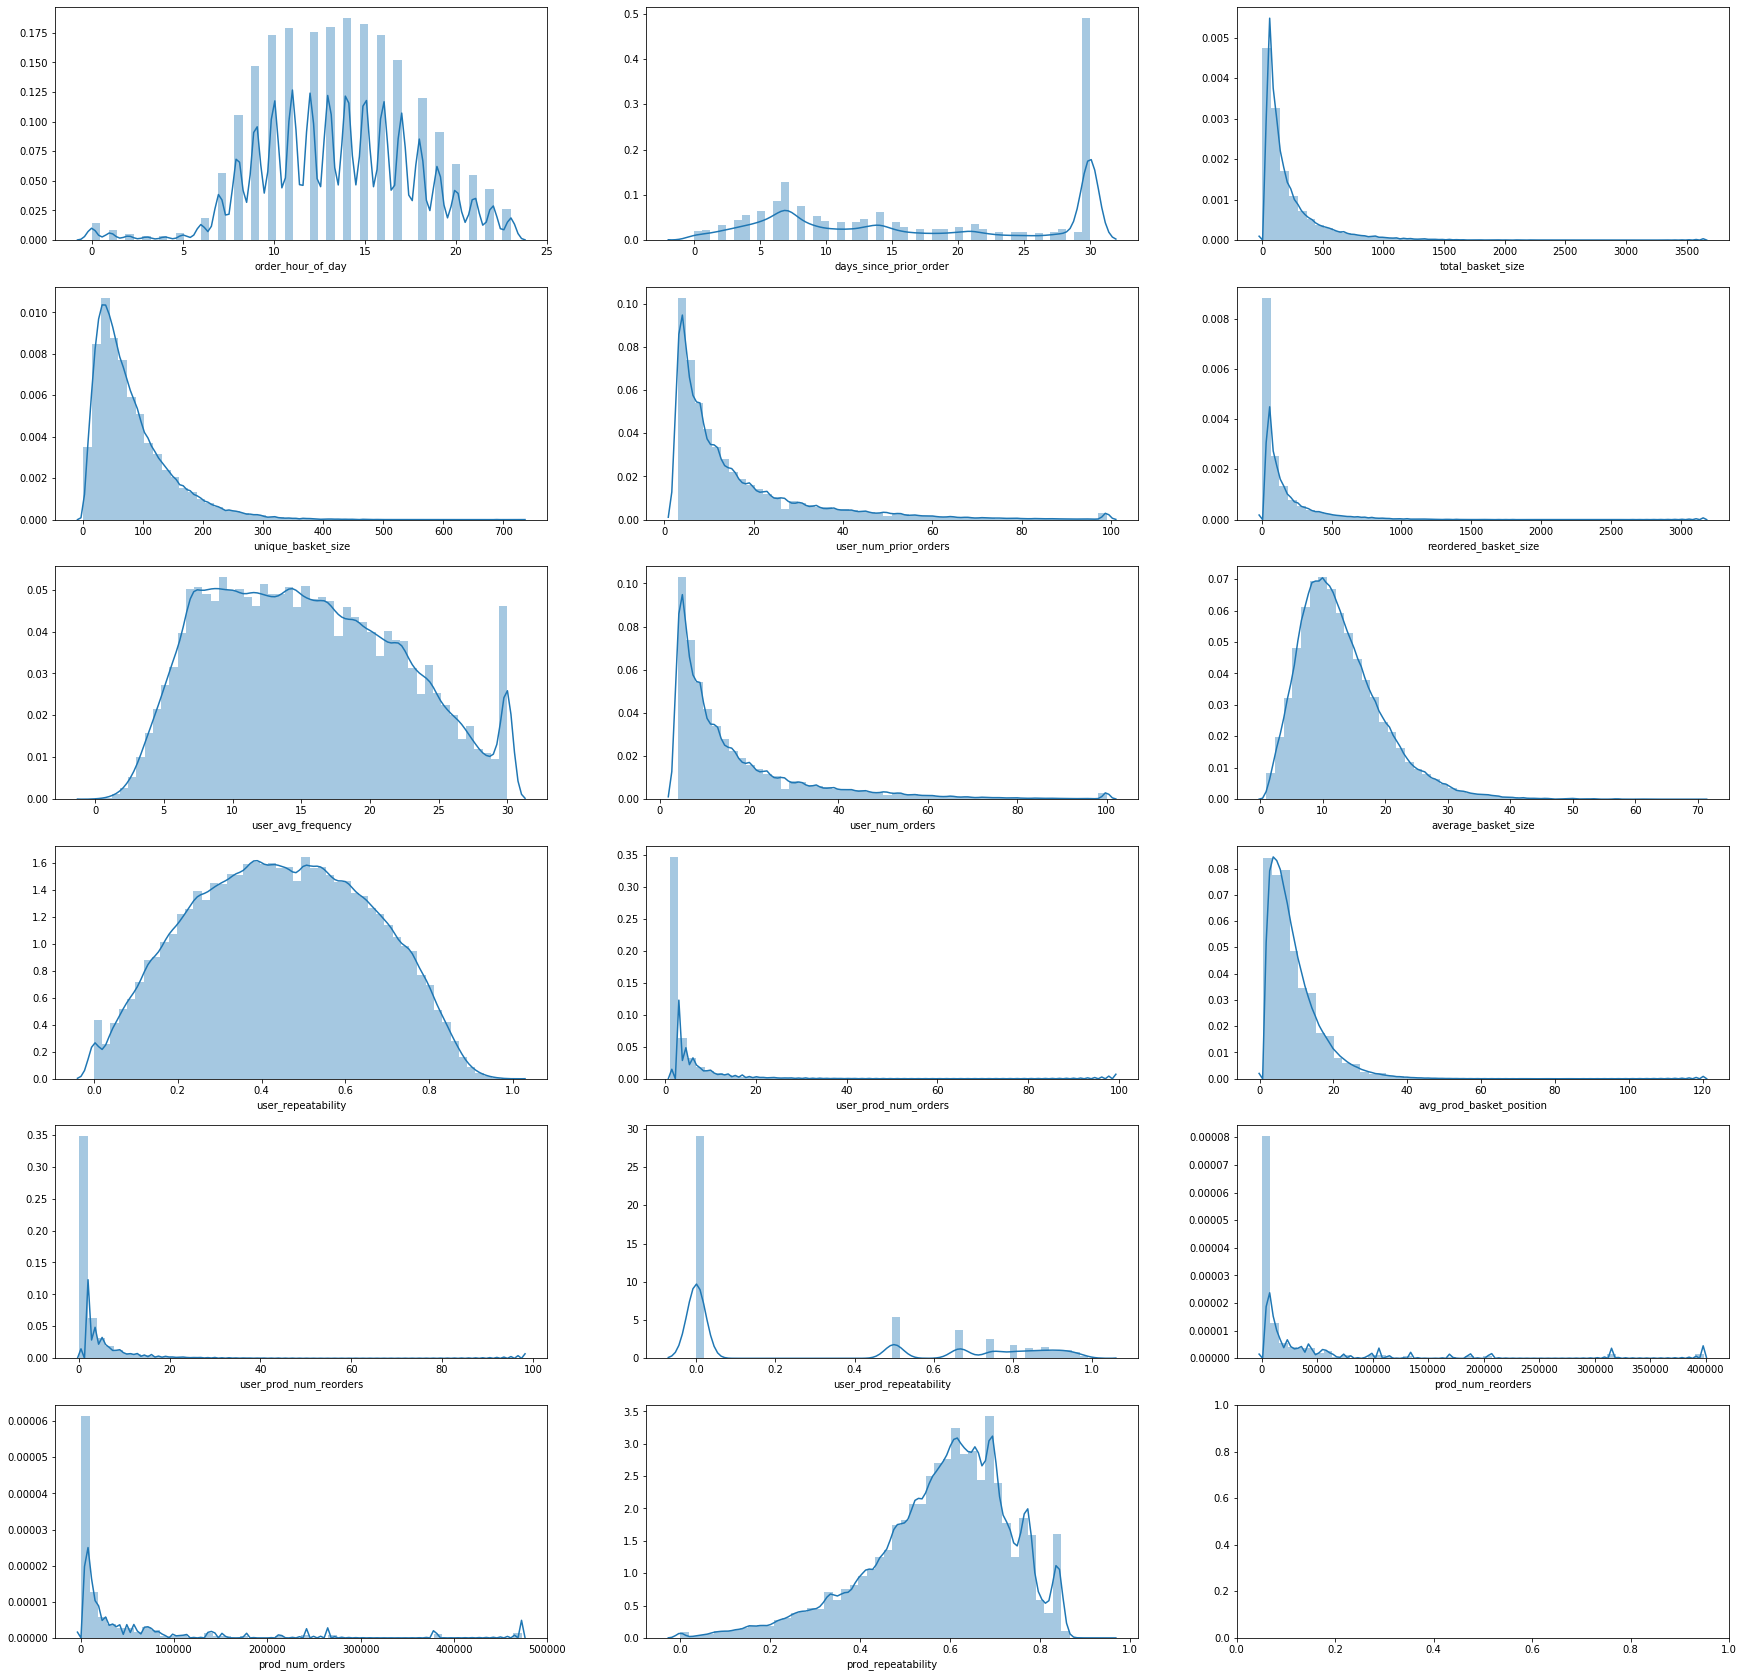

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows = 6, ncols = 3 ,figsize=(30,30))
flat_ax = [item for sublist in ax for item in sublist]
for i,feature in enumerate(num_features):
     sns.distplot(train_df[feature],ax=flat_ax[i])

In [0]:
def get_normalization_parameters(traindf, features):
    """Get the normalization parameters (E.g., mean, std) for traindf for 
    features. We will use these parameters for training, eval, and serving."""

    def z_score_params(column):
        mean = np.float32(traindf[column].mean())
        std = np.float32(traindf[column].std())
        min = np.float32(traindf[column].min())
        max = np.float32(traindf[column].max())

        return {'mean': mean, 'std': std,'min':min,'max':max}

    normalization_parameters = {}
    for column in features:
        normalization_parameters[column] = z_score_params(column)
    return normalization_parameters
#normalization_parameters = get_normalization_parameters(x_train, num_features)
normalization_parameters = get_normalization_parameters(train_df, num_features)
print(normalization_parameters)

{'order_hour_of_day': {'mean': 13.577586, 'std': 4.238456, 'min': 0.0, 'max': 23.0}, 'days_since_prior_order': {'mean': 17.066156, 'std': 10.42642, 'min': 0.0, 'max': 30.0}, 'total_basket_size': {'mean': 207.57744, 'std': 247.88081, 'min': 3.0, 'max': 3638.0}, 'unique_basket_size': {'mean': 81.414764, 'std': 62.598648, 'min': 1.0, 'max': 726.0}, 'user_num_prior_orders': {'mean': 16.091412, 'std': 16.614069, 'min': 3.0, 'max': 99.0}, 'reordered_basket_size': {'mean': 126.162674, 'std': 197.51443, 'min': 0.0, 'max': 3167.0}, 'user_avg_frequency': {'mean': 15.318091, 'std': 6.795476, 'min': 0.0, 'max': 30.0}, 'user_num_orders': {'mean': 17.091412, 'std': 16.614069, 'min': 4.0, 'max': 100.0}, 'average_basket_size': {'mean': 12.952141, 'std': 6.7662363, 'min': 1.0, 'max': 70.25}, 'user_repeatability': {'mean': 0.44721356, 'std': 0.20843686, 'min': 0.0, 'max': 0.9895288}, 'user_prod_num_orders': {'mean': 3.462198, 'std': 5.584559, 'min': 1.0, 'max': 99.0}, 'avg_prod_basket_position': {'mean'

In [0]:
num_features_s = []
for feature in num_features:
    train_df[feature+'_s'] = (train_df[feature]-normalization_parameters[feature]['min'])/(normalization_parameters[feature]['max']-normalization_parameters[feature]['min'])
    num_features_s.extend([feature+'_s'])
    print(feature)
tot_features_s = list(set(num_features_s)|set(cat_features))    

order_hour_of_day
days_since_prior_order
total_basket_size
unique_basket_size
user_num_prior_orders
reordered_basket_size
user_avg_frequency
user_num_orders
average_basket_size
user_repeatability
user_prod_num_orders
avg_prod_basket_position
user_prod_num_reorders
user_prod_repeatability
prod_num_reorders
prod_num_orders
prod_repeatability


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_eval, y_train, y_eval = train_test_split(train_df[tot_features_s], train_df['reordered'], test_size=0.2)

In [0]:
del train_df,all_orders,prior_orders_extended,prior_orders,train_set,all_products

In [0]:
import tensorflow as tf

tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

In [0]:
fc = tf.feature_column
all_features = []

def std_scaler(feature,mean,std):
      return (feature - mean)/std

for feature_name in cat_features:
  # Need to one-hot encode categorical features.
    vocabulary = x_train[feature_name].unique()
    all_features.append(fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,vocabulary)))

for feature_name in num_features_s:
#     fet_mean = normalization_parameters[feature_name]['mean']
#     fet_std = normalization_parameters[feature_name]['std']
    all_features.append(fc.numeric_column(feature_name,dtype=tf.float32,\
           # normalizer_fn=lambda x:((x-fet_mean)/fet_std)\
                       ))


In [0]:
print(len(all_features))
all_features

20


[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='aisle_id', vocabulary_list=(107, 129, 83, 120, 84, 78, 69, 24, 31, 21, 13, 96, 72, 86, 54, 4, 123, 45, 39, 121, 67, 98, 93, 115, 23, 16, 106, 32, 19, 89, 77, 131, 3, 35, 79, 127, 116, 9, 53, 91, 59, 75, 61, 42, 117, 57, 88, 40, 29, 104, 112, 114, 38, 44, 41, 26, 50, 36, 27, 51, 1, 8, 92, 122, 80, 94, 110, 17, 20, 81, 85, 105, 74, 52, 99, 63, 100, 108, 65, 34, 43, 37, 95, 49, 66, 101, 111, 90, 47, 48, 30, 64, 125, 14, 6, 5, 22, 128, 130, 126, 25, 71, 124, 2, 15, 56, 82, 87, 97, 11, 70, 12, 18, 28, 118, 55, 62, 76, 7, 109, 60, 46, 58, 132, 119, 73, 133, 113, 10, 68, 134, 33, 103, 102), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='department_id', vocabulary_list=(19, 1, 4, 16, 15, 7, 20, 13, 17, 9, 12, 14, 3, 11, 8, 5, 18, 21, 6, 2, 10), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=Vocabula

In [0]:
example = x_train.head(1)

In [0]:
fc.input_layer(dict(example), all_features)

<tf.Tensor: id=317, shape=(1, 179), dtype=float32, numpy=
array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.

In [0]:
x_train.shape,x_eval.shape

((1107686, 20), (276922, 20))

In [0]:
NUM_EXAMPLES = len(y_train) #1107693

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
          dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).    
        dataset = dataset.repeat(n_epochs)  
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

train_input_fn = make_input_fn(x_train.head(800), y_train.head(800))
eval_input_fn = make_input_fn(x_eval.head(1000), y_eval.head(1000), shuffle=False, n_epochs=1)

In [0]:
linear_est = tf.estimator.LinearClassifier(all_features)

# Train model.
linear_est.train(train_input_fn, max_steps=10)

# Evaluation.
results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.686
Dummy model:  0.592


In [0]:
def populate_features(df,chosen_features):
    df_new = df.merge(cust_attribs,how='left',on='user_id').\
        merge(user_prod_attribs,how='left',on='user_id').\
        merge(prod_attribs,how='left',on='product_id').\
        merge(train_set,how='left',on=['order_id','product_id']).\
        merge(all_products,how='left',on='product_id')
    return df_new[chosen_features]